In [1]:
!pip install timm

import zipfile
import os
import timm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from google.colab import drive

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 11.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
drive.mount('/content/drive')
zip = zipfile.ZipFile('/content/drive/MyDrive/archive.zip','r')
zip.extractall('/tmp')
zip.close()

Mounted at /content/drive


In [11]:
########################################################################
# Custom Dataset Class

class FruitDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        label = int(self.annotations.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

########################################################################
# Transforms

resize_size = 224  # Resize images to 224x224 pixels

transform_train = transforms.Compose([
    transforms.Resize((resize_size, resize_size)),
    transforms.RandomResizedCrop(resize_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transform_test = transforms.Compose([
    transforms.Resize((resize_size, resize_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

########################################################################
# Create Datasets and DataLoaders

train_dataset = FruitDataset(csv_file='/tmp/train.csv', root_dir='/tmp', transform=transform_train)
val_dataset = FruitDataset(csv_file='/tmp/val.csv', root_dir='/tmp', transform=transform_test)
test_dataset = FruitDataset(csv_file='/tmp/test.csv', root_dir='/tmp', transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

########################################################################
# Determine the number of classes
num_classes = len(pd.read_csv('/tmp/train.csv')['category'].unique())

########################################################################
# Define a Neural Network

# Use timm to load a pre-trained model
m = timm.create_model("rexnet_150", pretrained=True, num_classes=num_classes)

########################################################################
# Define a function for training setup

def train_setup(m):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    return m.to(device), 10, device, nn.CrossEntropyLoss(), optim.Adam(params=m.parameters(), lr=3e-4)

def to_device(batch, device):
    return batch[0].to(device), batch[1].to(device)

def get_metrics(model, ims, gts, loss_fn, epoch_loss, epoch_acc):
    preds = model(ims)
    loss = loss_fn(preds, gts)
    return loss, epoch_loss + loss.item(), epoch_acc + (torch.argmax(preds, dim=1) == gts).sum().item()

m, epochs, device, loss_fn, optimizer = train_setup(m)

########################################################################
# Training Loop

save_prefix, save_dir = "fruits", "saved_models"
print("Start training...")
best_acc, best_loss, threshold = 0, float("inf"), 0.01
tr_losses, val_losses, tr_accs, val_accs, test_accs = [], [], [], [], []

for epoch in range(epochs):

    # Training Phase
    epoch_loss, epoch_acc = 0, 0
    m.train()
    for idx, batch in tqdm(enumerate(train_loader)):
        ims, gts = to_device(batch, device)
        optimizer.zero_grad()
        loss, epoch_loss, epoch_acc = get_metrics(m, ims, gts, loss_fn, epoch_loss, epoch_acc)
        loss.backward()
        optimizer.step()

    tr_loss_to_track = epoch_loss / len(train_loader)
    tr_acc_to_track = epoch_acc / len(train_loader.dataset)
    tr_losses.append(tr_loss_to_track)
    tr_accs.append(tr_acc_to_track)

    print(f"{epoch + 1}-epoch train process is completed!\n")
    print(f"{epoch + 1}-epoch train loss          -> {tr_loss_to_track:.3f}")
    print(f"{epoch + 1}-epoch train accuracy      -> {tr_acc_to_track:.3f}")

    # Validation Phase
    m.eval()
    with torch.no_grad():
        val_epoch_loss, val_epoch_acc = 0, 0
        for idx, batch in enumerate(val_loader):
            ims, gts = to_device(batch, device)
            loss, val_epoch_loss, val_epoch_acc = get_metrics(m, ims, gts, loss_fn, val_epoch_loss, val_epoch_acc)

        val_loss_to_track = val_epoch_loss / len(val_loader)
        val_acc_to_track = val_epoch_acc / len(val_loader.dataset)
        val_losses.append(val_loss_to_track)
        val_accs.append(val_acc_to_track)

        print(f"{epoch + 1}-epoch validation process is completed!")
        print(f"{epoch + 1}-epoch validation loss     -> {val_loss_to_track:.3f}")
        print(f"{epoch + 1}-epoch validation accuracy -> {val_acc_to_track:.3f} \n")

        if val_loss_to_track < (best_loss + threshold):
            os.makedirs(save_dir, exist_ok=True)
            best_loss = val_loss_to_track
            torch.save(m.state_dict(), f"{save_dir}/{save_prefix}_best_model.pth")

print("Finished Training")

Start training...


10000it [09:33, 17.42it/s]

1-epoch train process is completed!

1-epoch train loss          -> 2.302
1-epoch train accuracy      -> 0.419


1-epoch validation process is completed!
1-epoch validation loss     -> 1.474
1-epoch validation accuracy -> 0.626 



10000it [09:24, 17.73it/s]

2-epoch train process is completed!

2-epoch train loss          -> 1.535
2-epoch train accuracy      -> 0.583


2-epoch validation process is completed!
2-epoch validation loss     -> 1.242
2-epoch validation accuracy -> 0.691 



10000it [09:28, 17.59it/s]

3-epoch train process is completed!

3-epoch train loss          -> 1.326
3-epoch train accuracy      -> 0.635


3-epoch validation process is completed!
3-epoch validation loss     -> 1.203
3-epoch validation accuracy -> 0.714 



10000it [09:26, 17.66it/s]

4-epoch train process is completed!

4-epoch train loss          -> 1.205
4-epoch train accuracy      -> 0.662


4-epoch validation process is completed!
4-epoch validation loss     -> 1.028
4-epoch validation accuracy -> 0.746 



10000it [09:29, 17.57it/s]

5-epoch train process is completed!

5-epoch train loss          -> 1.120
5-epoch train accuracy      -> 0.684


5-epoch validation process is completed!
5-epoch validation loss     -> 0.983
5-epoch validation accuracy -> 0.760 



10000it [09:28, 17.58it/s]

6-epoch train process is completed!

6-epoch train loss          -> 1.069
6-epoch train accuracy      -> 0.695


6-epoch validation process is completed!
6-epoch validation loss     -> 1.005
6-epoch validation accuracy -> 0.758 



10000it [09:31, 17.51it/s]

7-epoch train process is completed!

7-epoch train loss          -> 1.005
7-epoch train accuracy      -> 0.711


7-epoch validation process is completed!
7-epoch validation loss     -> 1.002
7-epoch validation accuracy -> 0.759 



10000it [09:27, 17.62it/s]

8-epoch train process is completed!

8-epoch train loss          -> 0.973
8-epoch train accuracy      -> 0.723


8-epoch validation process is completed!
8-epoch validation loss     -> 1.054
8-epoch validation accuracy -> 0.751 



10000it [09:28, 17.60it/s]

9-epoch train process is completed!

9-epoch train loss          -> 0.925
9-epoch train accuracy      -> 0.735


9-epoch validation process is completed!
9-epoch validation loss     -> 0.950
9-epoch validation accuracy -> 0.765 



10000it [09:22, 17.79it/s]

10-epoch train process is completed!

10-epoch train loss          -> 0.895
10-epoch train accuracy      -> 0.742


10-epoch validation process is completed!
10-epoch validation loss     -> 0.932
10-epoch validation accuracy -> 0.772 

Finished Training


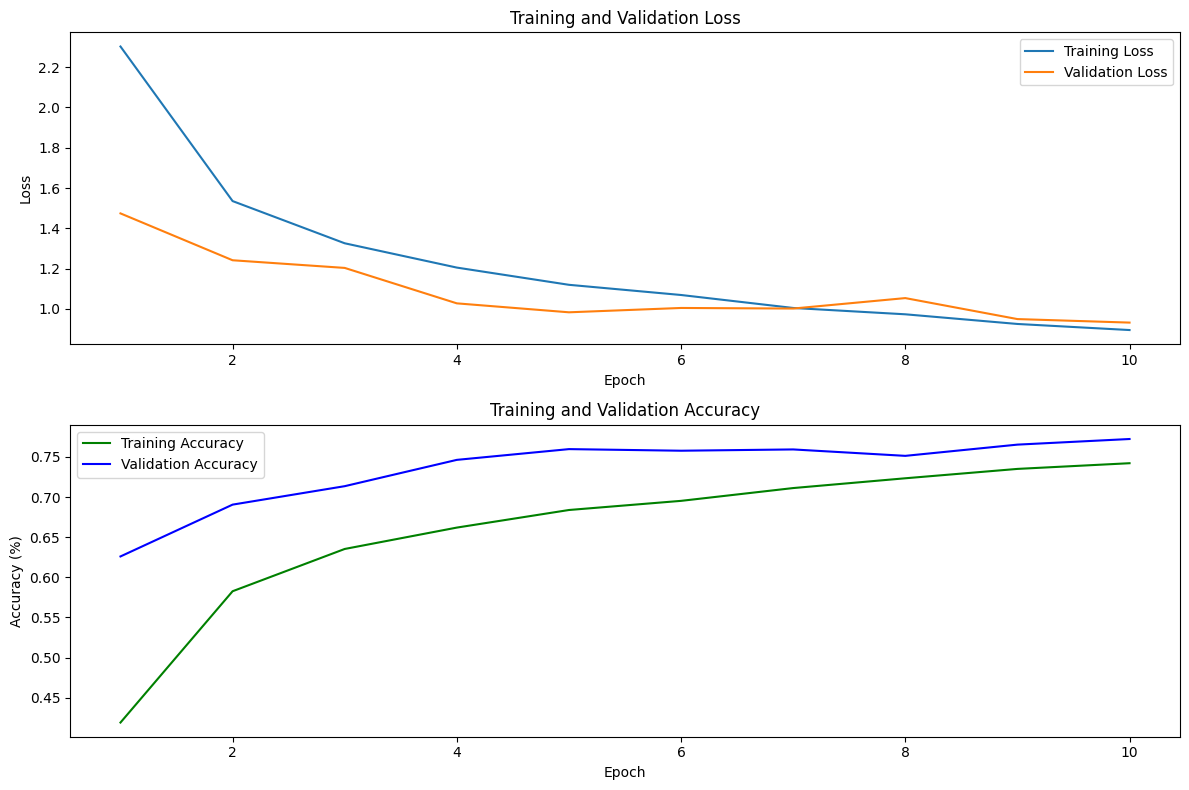

In [12]:

# Plot the results
epochs = range(1, len(tr_losses) + 1)

plt.figure(figsize=(12, 8))

# Plot Training and Validation Loss
plt.subplot(2, 1, 1)
plt.plot(epochs, tr_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(2, 1, 2)
plt.plot(epochs, tr_accs, label='Training Accuracy', color='g')
plt.plot(epochs, val_accs, label='Validation Accuracy', color='b')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()